In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dataclasses import dataclass
from scipy.interpolate  import CubicSpline
from Levy_cfs import SVJparams, HestonParams, KouParams, VGBparams
from Levy_cfs import SVJ_cf_St, Heston_cf_St, Kou_cf_St, VGB_cf_St
from COS_Fourier import European_Call, European_Put
from scipy.optimize import minimize
from risk_neutral_density import plot_risk_neutral_density_St

In [2]:
df = pd.read_csv("OptionChain_SPY 01-Dec-25_20251201.csv", header = 1)
df.head()
S0 = 682.83

In [3]:
def process_dataframe(df, iv_threshold = 5.0):
    df = df[["Volume","Bid IV", "Bid Price", "Ask IV", "Ask Price", "Strike Price","Volume.1","Bid IV.1", "Bid Price.1", "Ask IV.1", "Ask Price.1"]]
    df = df.rename(columns = {"Volume": "Call Volume",
                              "Bid IV": "Call Bid IV",
                              "Bid Price": "Call Bid Price",
                              "Ask IV": "Call Ask IV",
                              "Ask Price": "Call Ask Price",
                              "Volume.1": "Put Volume",
                              "Bid IV.1": "Put Bid IV",
                              "Bid Price.1": "Put Bid Price",
                              "Ask IV.1": "Put Ask IV",
                              "Ask Price.1": "Put Ask Price"})
    
    df = df[(df["Call Bid Price"] > 0.0) & (df["Call Ask Price"]) & (df["Put Bid Price"]) & (df["Put Ask Price"])]
    df = df[(np.abs(df["Call Ask IV"] - df["Call Bid IV"])) < iv_threshold]
    df = df[(np.abs(df["Put Ask IV"] - df["Put Bid IV"])) < iv_threshold]
    df["Call Mid IV"] = (df["Call Ask IV"] + df["Call Bid IV"]) / 2
    df["Put Mid IV"] = (df["Put Ask IV"] + df["Call Ask IV"]) / 2
    df["Call Mid Price"] = (df["Call Ask Price"] + df["Call Bid Price"]) / 2
    df["Put Mid Price"] = (df["Put Ask Price"] + df["Put Bid Price"]) / 2
    # weight equal to inverse of bid_ask spread * volume 
    df["call_weight"] = 1.0 / (df["Call Ask Price"] - df["Call Bid Price"]) * df["Call Volume"]
    df["put_weight"] = 1.0 / (df["Put Ask Price"] - df["Put Bid Price"]) * df["Put Volume"]
    return df

df = process_dataframe(df)
df.head()


,Call Volume,Call Bid IV,Call Bid Price,Call Ask IV,Call Ask Price,Strike Price,Put Volume,Put Bid IV,Put Bid Price,Put Ask IV,Put Ask Price,Call Mid IV,Put Mid IV,Call Mid Price,Put Mid Price,call_weight,put_weight
79,73425,7.00,3.83,9.29,3.88,679,252888,9.08,0.04,9.47,0.05,8.145,9.380,3.855,0.045,1.468500e+06,25288800.0
80,235421,7.68,2.88,8.25,2.91,680,339484,7.70,0.06,7.95,0.07,7.965,8.100,2.895,0.065,7.847367e+06,33948400.0
81,378335,6.17,1.91,6.75,1.95,681,282832,6.38,0.10,6.53,0.11,6.460,6.640,1.930,0.105,9.458375e+06,28283200.0
82,574348,5.48,1.05,5.63,1.07,682,250738,5.63,0.24,5.72,0.25,5.555,5.675,1.060,0.245,2.871740e+07,25073800.0
83,559543,5.23,0.44,5.29,0.45,683,96388,5.29,0.62,5.33,0.63,5.260,5.310,0.445,0.625,5.595430e+07,9638800.0


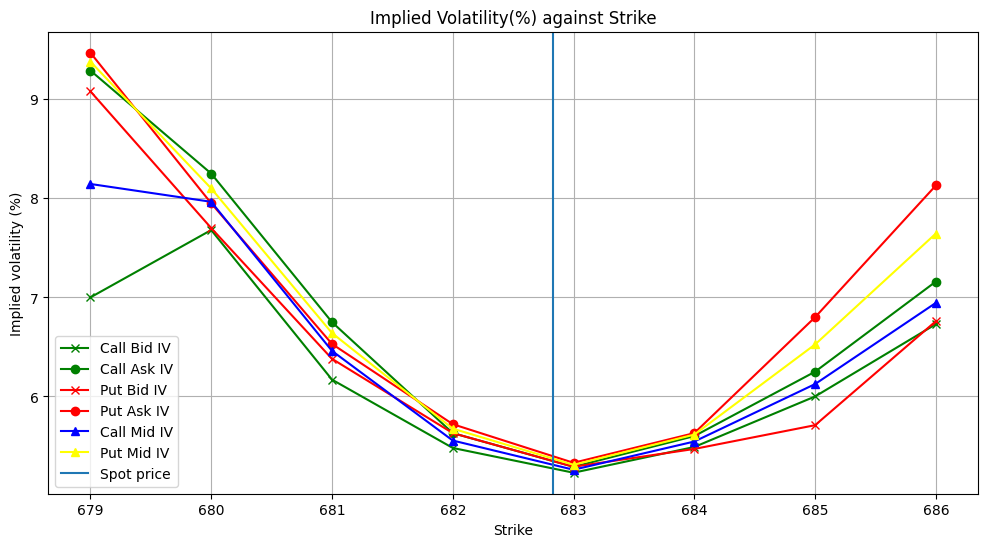

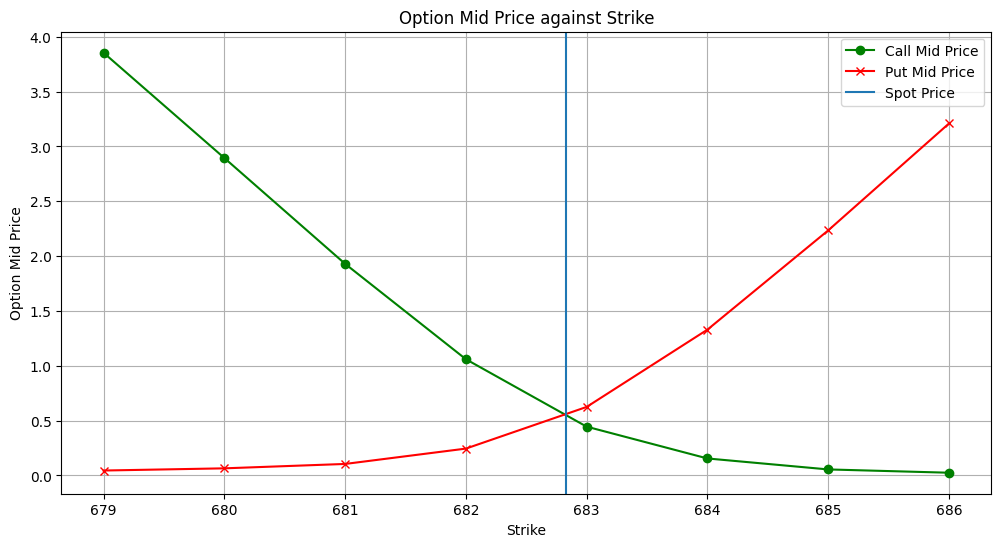

In [4]:
def plot_market_iv(df):
    fig = plt.figure(figsize = (12,6))
    plt.plot(df["Strike Price"], df["Call Bid IV"], color = 'green', marker = 'x', label = "Call Bid IV")
    plt.plot(df["Strike Price"], df["Call Ask IV"], color = "green", marker = "o", label = "Call Ask IV")
    plt.plot(df["Strike Price"], df["Put Bid IV"], color = "red", marker = "x", label = "Put Bid IV")
    plt.plot(df["Strike Price"], df["Put Ask IV"], color = "red", marker = "o", label = "Put Ask IV")
    plt.plot(df["Strike Price"], df["Call Mid IV"], color = "blue", marker = "^", label = "Call Mid IV")
    plt.plot(df["Strike Price"], df["Put Mid IV"], color = "yellow", marker = "^", label = "Put Mid IV")
    plt.axvline(x = S0, label = "Spot price")
    plt.xlabel("Strike")
    plt.ylabel("Implied volatility (%)")
    plt.title("Implied Volatility(%) against Strike")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_call_put_prices(df):
    fig = plt.figure(figsize = (12,6))
    plt.plot(df["Strike Price"], df["Call Mid Price"], color = 'green', marker = "o", label = "Call Mid Price")
    plt.plot(df["Strike Price"], df["Put Mid Price"], color = "red", marker = "x", label = "Put Mid Price")
    plt.axvline(x = S0, label = "Spot Price")
    plt.xlabel("Strike")
    plt.ylabel("Option Mid Price")
    plt.title("Option Mid Price against Strike")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_market_iv(df)
plot_call_put_prices(df)



In [5]:
def time_to_expiry(todays_date:datetime, expiry_date:datetime):
    delta = expiry_date - todays_date
    return delta.seconds / (365 * 24 * 60 * 60)

todays_date = datetime(2025, 12, 1, 14, 00)
expiry_date = datetime(2025, 12, 1, 16, 00)
T = time_to_expiry(todays_date, expiry_date)
r = 0.01 # 1%. For 0DTE options because time to expiry is approximately equal to zero e^(-rT) is very close to 1.

In [ ]:


# Calibration of SVJ surface
def objective(x):
    error = 0.0
    
    for _, row in df.iterrows():
        K = row["Strike Price"]
        call_mid = row["Call Mid Price"]
        call_weight = row["call_weight"]
        put_weight = row["put_weight"]
        put_mid = row["Put Mid Price"]
        p = SVJparams(kappa = x[0], sigma = x[1], theta = x[2], v0 = x[3], rho = x[4], lamda = x[5], mu_j = x[6], sigma_j = x[7])
        C_model = European_Call(SVJ_cf_St, S0, K, T, r, 0.0, p)
        P_model = European_Put(SVJ_cf_St, S0, K, T, r, 0.0, p)
        error += (C_model - row["Call Mid Price"]) ** 2 + (P_model - row["Put Mid Price"]) ** 2
    return error

# initial parameters guess
p0 = np.array([20.0,0.8,0.04,0.04,-0.6,10.0,0.3,0.1])

bounds = [
    (1e-4, 40.0),    # kappa   ∈ (0, 40]
    (1e-4,  5.0),    # sigma   ∈ (0, 5]
    (1e-4,  4.0),    # theta   ∈ (0, 4]
    (1e-6,  3.0),    # v0      ∈ (0, 3]
    (-0.999, 0.999), # rho     ∈ (-0.999, 0.999)
    (0.0,   100.0),    # lamda   ∈ [0, 100]
    (-40.0,  40.0),    # mu_j    ∈ [-40.0, 40.0] 
    (1e-4,  1.0),    # sigma_j ∈ (0, 1] 
]

svj_res = minimize(objective,
               p0,
               method = "L-BFGS-B",
               options={"maxiter": 500},
               bounds = bounds)

svj_x_opt = svj_res.x

In [ ]:
# Calibration of Heston Surface

def objective(x):
    error = 0.0
    
    for _, row in df.iterrows():
        K = row["Strike Price"]
        call_mid = row["Call Mid Price"]
        call_weight = row["call_weight"]
        put_weight = row["put_weight"]
        put_mid = row["Put Mid Price"]
        p = HestonParams(kappa = x[0], sigma = x[1], theta = x[2], v0 = x[3], rho = x[4])
        C_model = European_Call(Heston_cf_St, S0, K, T, r, 0.0, p)
        P_model = European_Put(Heston_cf_St, S0, K, T, r, 0.0, p)
        # Feller Square Root condition
        error += (C_model - row["Call Mid Price"]) ** 2 + (P_model - row["Put Mid Price"]) ** 2 
    error += (x[1] ** 2 - 2 * x[0] * x[2])
    return error

# initial parameters guess
p0 = np.array([9.99,0.8,0.04,0.04,-0.6])

bounds = [
    (1e-4, 10.0),    # kappa   ∈ (0, 10]
    (1e-4,  5.0),    # sigma   ∈ (0, 5]
    (1e-4,  5.0),    # theta   ∈ (0, 5]
    (1e-6,  5.0),    # v0      ∈ (0, 5]
    (-0.999, 0.999), # rho     ∈ (-0.999, 0.999)
]

heston_res = minimize(objective,
               p0,
               method = "L-BFGS-B",
               options={"maxiter": 500},
               bounds = bounds)

heston_x_opt = heston_res.x

In [ ]:
# Calibration of Kou Model

def objective(x):
    error = 0.0
    
    for _, row in df.iterrows():
        K = row["Strike Price"]
        call_mid = row["Call Mid Price"]
        call_weight = row["call_weight"]
        put_weight = row["put_weight"]
        put_mid = row["Put Mid Price"]
        p = KouParams(lamda = x[0], sigma = x[1], prob = x[2], eta_plus = x[3], eta_minus = x[4])
        C_model = European_Call(Kou_cf_St, S0, K, T, r, 0.0, p)
        P_model = European_Put(Kou_cf_St, S0, K, T, r, 0.0, p)
        error += (C_model - row["Call Mid Price"]) ** 2 + (P_model - row["Put Mid Price"]) ** 2 
    return error

# initial parameters guess
p0 = np.array([30.0,0.45,0.60,80.0,40.0])

bounds = [
    (1e-4, 40.0),    # lamda   ∈ (0, 40]
    (1e-4,  5.0),    # sigma   ∈ (0, 5]
    (1e-4,  1.0),    # prob   ∈ (0, 1]
    (1e-4,  100.0),   # eta_plus     ∈ (0, 100.00]
    (1e-4, 100.0),    # eta_minus     ∈ (0, 100.00)
]

kou_res = minimize(objective,
               p0,
               method = "L-BFGS-B",
               options={"maxiter": 500},
               bounds = bounds)

kou_x_opt = kou_res.x

In [ ]:
# Calibration of VGB model


def objective(x):
    error = 0.0
    
    for _, row in df.iterrows():
        K = row["Strike Price"]
        call_mid = row["Call Mid Price"]
        call_weight = row["call_weight"]
        put_weight = row["put_weight"]
        put_mid = row["Put Mid Price"]
        p = VGBparams(beta = x[0], eta = x[1], sigma = x[2], theta = x[3])
        C_model = European_Call(VGB_cf_St, S0, K, T, r, 0.0, p)
        P_model = European_Put(VGB_cf_St, S0, K, T, r, 0.0, p)
        # Impose constraint
        error += (C_model - row["Call Mid Price"]) ** 2 + (P_model - row["Put Mid Price"]) ** 2 
    error += (x[3] + 0.5 * x[1]**2 - 1.0/x[0])
    
    return error

# initial parameters guess
p0 = np.array([0.3,0.05,0.01,0.60])

bounds = [
    (1e-4, 5.0),    # beta   ∈ (0, 5.0]
    (1e-4,  1.0),    # eta   ∈ (0, 1]
    (1e-4,  1.0),    # sigma  ∈ (0, 1]
    (-10.0,  5.0),   # theta     ∈ (-10, 5.0]
 
]

vgb_res = minimize(objective,
               p0,
               method = "L-BFGS-B",
               options={"maxiter": 500},
               bounds = bounds)

vgb_x_opt = vgb_res.x

In [40]:
opt_SVJ_params = SVJparams(kappa = svj_x_opt[0],
                           sigma = svj_x_opt[1],
                           theta = svj_x_opt[2],
                           v0    = svj_x_opt[3],
                           rho   = svj_x_opt[4],
                           lamda = svj_x_opt[5],
                           mu_j = svj_x_opt[6],
                           sigma_j = svj_x_opt[7]
                                   )

opt_Heston_params = HestonParams(
                                kappa = heston_x_opt[0],
                                sigma = heston_x_opt[1],
                                theta = heston_x_opt[2],
                                v0 = heston_x_opt[3],
                                rho = heston_x_opt[4])

opt_Kou_params = KouParams(lamda= kou_x_opt[0],
                           sigma = kou_x_opt[1],
                           prob = kou_x_opt[2],
                           eta_plus=kou_x_opt[3],
                           eta_minus=kou_x_opt[4])

opt_VGB_params = VGBparams(beta = vgb_x_opt[0],
                           eta = vgb_x_opt[1],
                           sigma = vgb_x_opt[2],
                           theta = vgb_x_opt[3])


SVJ_calls = np.array([])
SVJ_puts = np.array([])
Heston_calls = np.array([])
Heston_puts = np.array([])
Kou_calls = np.array([])
Kou_puts = np.array([])
VGB_calls = np.array([])
VGB_puts = np.array([])

for strike in df["Strike Price"]:
    SVJ_calls = np.append(SVJ_calls,np.round(European_Call(SVJ_cf_St, S0, strike, T, r, 0.0, opt_SVJ_params),2))
    SVJ_puts = np.append(SVJ_puts, np.round(European_Put(SVJ_cf_St, S0, strike, T, r, 0.0, opt_SVJ_params),2))
    Heston_calls = np.append(Heston_calls,np.round(European_Call(Heston_cf_St, S0, strike, T, r, 0.0, opt_Heston_params),2))
    Heston_puts = np.append(Heston_puts,np.round(European_Put(Heston_cf_St, S0, strike, T, r, 0.0, opt_Heston_params),2))
    Kou_calls = np.append(Kou_calls,np.round(European_Call(Kou_cf_St, S0, strike, T, r, 0.0, opt_Kou_params),2))
    Kou_puts = np.append(Kou_puts,np.round(European_Put(Kou_cf_St, S0, strike, T, r, 0.0, opt_Kou_params),2))
    VGB_calls = np.append(VGB_calls,np.round(European_Call(VGB_cf_St, S0, strike, T, r, 0.0, opt_VGB_params),2))
    VGB_puts = np.append(VGB_puts,np.round(European_Put(VGB_cf_St, S0, strike, T, r, 0.0, opt_VGB_params),2))

df["SVJ call price"] = SVJ_calls
df["SVJ put price"] = SVJ_puts
df["Heston call price"] = Heston_calls
df["Heston put price"] = Heston_puts
df["Kou call price"] = Kou_calls
df["Kou put price"] = Kou_puts
df["VGB call price"] = VGB_calls
df["VGB put price"] = VGB_puts

df.head()
                     



,Call Volume,Call Bid IV,Call Bid Price,Call Ask IV,Call Ask Price,Strike Price,Put Volume,Put Bid IV,Put Bid Price,Put Ask IV,...,call_weight,put_weight,SVJ call price,SVJ put price,Heston call price,Heston put price,Kou call price,Kou put price,VGB call price,VGB put price
79,73425,7.00,3.83,9.29,3.88,679,252888,9.08,0.04,9.47,...,1.468500e+06,25288800.0,3.88,0.05,3.83,0.00,3.88,0.05,3.84,0.01
80,235421,7.68,2.88,8.25,2.91,680,339484,7.70,0.06,7.95,...,7.847367e+06,33948400.0,2.89,0.06,2.84,0.01,2.89,0.06,2.87,0.04
81,378335,6.17,1.91,6.75,1.95,681,282832,6.38,0.10,6.53,...,9.458375e+06,28283200.0,1.92,0.09,1.90,0.07,1.92,0.09,1.94,0.10
82,574348,5.48,1.05,5.63,1.07,682,250738,5.63,0.24,5.72,...,2.871740e+07,25073800.0,1.07,0.24,1.08,0.24,1.07,0.24,1.10,0.27
83,559543,5.23,0.44,5.29,0.45,683,96388,5.29,0.62,5.33,...,5.595430e+07,9638800.0,0.46,0.63,0.49,0.65,0.46,0.63,0.47,0.64


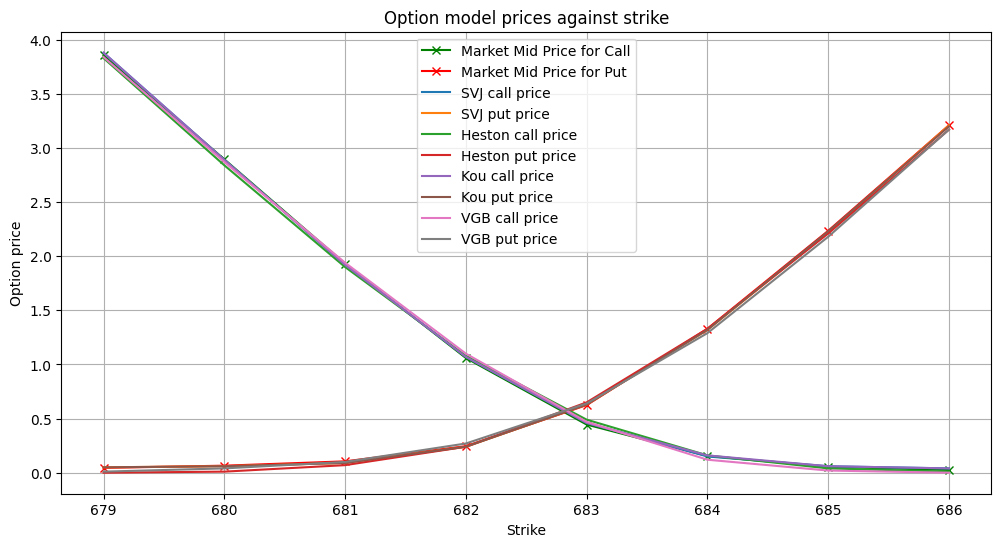

In [41]:
plt.figure(figsize=(12,6))
plt.plot(df["Strike Price"], df["Call Mid Price"], color = 'green', marker = "x", label = "Market Mid Price for Call")
plt.plot(df["Strike Price"], df["Put Mid Price"], color = 'red', marker = "x", label = "Market Mid Price for Put")
plt.plot(df["Strike Price"], df["SVJ call price"], label = "SVJ call price")
plt.plot(df["Strike Price"], df["SVJ put price"],  label = "SVJ put price")
plt.plot(df["Strike Price"], df["Heston call price"], label = "Heston call price")
plt.plot(df["Strike Price"], df["Heston put price"], label = "Heston put price")
plt.plot(df["Strike Price"], df["Kou call price"], label = "Kou call price")
plt.plot(df["Strike Price"], df["Kou put price"], label = "Kou put price")
plt.plot(df["Strike Price"], df["VGB call price"], label = "VGB call price")
plt.plot(df["Strike Price"], df["VGB put price"], label = "VGB put price")
plt.xlabel("Strike")
plt.ylabel("Option price")
plt.title("Option model prices against strike")
plt.grid(True)
plt.legend()

In [42]:
# Overall MAPE
cum_error = 0.0
for _, row in df.iterrows():
    cum_error += (np.abs(row["Call Mid Price"] - row["SVJ call price"] / row["Call Mid Price"])) 
    cum_error += (np.abs(row["Put Mid Price"] - row["SVJ put price"] / row["Put Mid Price"])) 
SVJ_MAPE = cum_error/(df.size * 2)
print(f"Mean Absolute Percentage Error for SVJ: {SVJ_MAPE * 100:.2f} %")

Mean Absolute Percentage Error for SVJ: 4.33 %


In [43]:
cum_error = 0.0
for _, row in df.iterrows():
    cum_error += (np.abs(row["Call Mid Price"] - row["Heston call price"] / row["Call Mid Price"])) 
    cum_error += (np.abs(row["Put Mid Price"] - row["Heston put price"] / row["Put Mid Price"])) 
Heston_MAPE = cum_error/(df.size * 2)
print(f"Mean Absolute Percentage Error for Heston: {Heston_MAPE * 100:.2f} %")

Mean Absolute Percentage Error for Heston: 3.50 %


In [44]:
cum_error = 0.0
for _, row in df.iterrows():
    cum_error += (np.abs(row["Call Mid Price"] - row["Kou call price"] / row["Call Mid Price"])) 
    cum_error += (np.abs(row["Put Mid Price"] - row["Kou put price"] / row["Put Mid Price"])) 
Kou_MAPE = cum_error/(df.size * 2)
print(f"Mean Absolute Percentage Error for Kou: {Kou_MAPE * 100:.2f} %")

Mean Absolute Percentage Error for Kou: 4.35 %


In [45]:
cum_error = 0.0
for _, row in df.iterrows():
    cum_error += (np.abs(row["Call Mid Price"] - row["VGB call price"] / row["Call Mid Price"])) 
    cum_error += (np.abs(row["Put Mid Price"] - row["VGB put price"] / row["Put Mid Price"])) 
VGB_MAPE = cum_error/(df.size * 2)
print(f"Mean Absolute Percentage Error for VGB: {VGB_MAPE * 100:.2f} %")

Mean Absolute Percentage Error for VGB: 3.49 %


# Model results

| Model | MAPE(%) | Calibration time(s)
|----------|----------|---------------|
| Heston   | 3.50 |  94     |
| SVJ      | 4.33 |  45.1   |
| Kou      | 4.35 |  18.6   |
| VGB      | 3.49 |  10.5   |
